# Overview
While attended the [Portland Data Science](https://www.meetup.com/Portland-Data-Science-Group) Natural Language meetups, I built the following classification algorithm for identifying toxic and non-toxic text in Wikipedia reviewed comments.  

#### The original data can be found here: http://dive-into.info/

### Imports used to clean data and Stem words

In [ ]:
import pandas as pd
import os
import re
import time
import numpy as np

import nltk
from nltk.stem import PorterStemmer
stem = PorterStemmer()

### Methods to import and clean the data files

In [2]:
def stem_in_place(someString):
    listOfStrings = someString.split(' ')
    return ' '.join([stem.stem(word) for word in listOfStrings])

def remove_long_words(someString):
    listOfStrings = someString.split(' ')
    return ' '.join([word for word in listOfStrings if len(word) < 30])

def cleanData():
    
    # read the comments and scores...
    df=pd.read_csv('toxicity_annotated_comments.tsv', sep='\t')
    scores=pd.read_csv('toxicity_annotations.tsv', sep='\t')

    df["mean_score"] = pd.Series(scores.groupby("rev_id",as_index=False).mean()["toxicity_score"])
    df["median_score"] = pd.Series(scores.groupby("rev_id",as_index=False).median()["toxicity_score"])

    # create catgorical variable toxicity_score: if mean_score < 0, toxicity_score=1, otherwise 0
    df["toxicity_score"] = (df["mean_score"] < 0).astype(int)
    0
    # Remove HTML elements, 'NEWLINE_TOKEN', UTC
    from bs4 import BeautifulSoup
    df.comment = df.comment.apply(lambda x: BeautifulSoup(x, 'html5lib').get_text())
    df.comment = df.comment.apply(lambda x: x.replace('NEWLINE_TOKEN', ' '))
    df.comment = df.comment.apply(lambda x: x.replace('UTC', ' '))
        
    
    # add extra features...
    df.logged_in = df.logged_in.astype(int)
    df['length'] = df.comment.apply(lambda x: len(x))
    df['num_exclamation_marks'] = df.comment.apply(lambda comment: comment.count('!'))
    df['num_words'] = df.comment.apply(lambda comment: len(comment.split()))
    df['num_unique_words'] = df.comment.apply(lambda comment: len(set(w for w in comment.split())))

    # remove all but word, lower, remove extra spaces (for readability)
    df.comment = df.comment.apply(lambda x: re.sub("[^a-zA-Z\s']", '', x))
    df.comment = df.comment.apply(str.lower)    
    df.comment = df.comment.str.replace('  ', ' ')
    df.comment = df.comment.str.strip()    
    df.comment = df.comment.apply(remove_long_words)
    
    # remove rows with blank comments...
    df = df[df.comment.str.len() > 0]
    
    # stem words using NLTK PorterStemmer...
    df.comment =df.comment.apply(stem_in_place)
    
    return df

## Open files and clean comment column

In [3]:
dfClean = cleanData()

In [4]:
dfClean.head()

,rev_id,comment,year,logged_in,ns,sample,split,mean_score,median_score,toxicity_score,length,num_exclamation_marks,num_words,num_unique_words
0,2232.0,thi one can make an analog in mathemat term by...,2002,1,article,random,train,0.4,0.5,0,651,0,109,85
1,4216.0,clarif for you and zundark' right i should hav...,2002,1,user,random,train,0.5,0.0,0,611,0,113,78
2,8953.0,elect or elector jhk,2002,0,article,random,test,0.1,0.0,0,25,0,4,4
3,26547.0,thi is such a fun entri devotchka i onc had a...,2002,1,article,random,train,0.6,0.0,0,2976,0,472,288
4,28959.0,pleas relat the ozon hole to increas in cancer...,2002,1,article,random,test,0.2,0.0,0,197,0,31,29


#### To save a little time use a percentage of the data

In [75]:
#df = dfClean.sample(frac=.2,random_state=200)
df = dfClean # 100%

## Use scikit-learn to split into train and test sets 

In [9]:
from sklearn.model_selection import train_test_split

train_set_df, test_set_df = train_test_split(df, test_size=0.2, random_state=987)
all_words_train = train_set_df.comment
all_words_test = test_set_df.comment


### Distribution of Comments

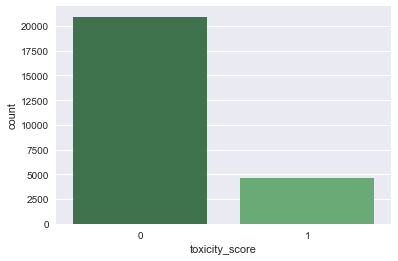

In [45]:
sns.countplot(x="toxicity_score", data=train_set_df, palette="Greens_d");

## Visualize Features

Use NLTK frequency distribution to review the top words in the corpus

In [25]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# tokenize to words
words = list(itertools.chain(*all_words_train.apply(word_tokenize).tolist()))

# remove stops
words = [word for word in words if word not in stopwords.words('english')]

# get the frequency distribution of each word and plot the top 50
fdist = nltk.FreqDist(words)  
print(fdist.most_common(50)) 

[('thi', 15661), ("'", 13833), ('articl', 11842), ('page', 9206), ("n't", 9044), ('wa', 8937), ('edit', 6451), ('wikipedia', 6171), ('use', 5514), ('ha', 5147), ('would', 4995), ('pleas', 4936), ('like', 4819), ('one', 4759), ('delet', 4321), ('ani', 4260), ('hi', 4133), ('sourc', 3745), ('thank', 3683), ('talk', 3566), ('see', 3547), ('think', 3538), ('know', 3369), ('make', 3344), ('also', 3340), ('becaus', 3035), ('peopl', 3032), ('time', 2977), ('go', 2896), ('get', 2884), ("'m", 2864), ('onli', 2783), ('whi', 2762), ('say', 2712), ('name', 2691), ('remov', 2584), ('need', 2569), ('may', 2538), ('block', 2524), ('discuss', 2402), ('person', 2399), ('want', 2385), ('link', 2346), ('help', 2252), ('look', 2205), ('work', 2199), ('even', 2170), ('inform', 2065), ('good', 2056), ('user', 2042)]


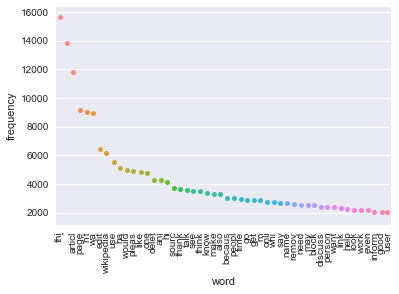

In [26]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# convert frequency dictionary to pandas dataframe...
fdistDF=pd.DataFrame.from_dict(fdist,orient='index')
fdistDF.columns = ['frequency']
fdistDF['word'] = fdistDF.index

# use the top 100...
fdistDF = fdistDF.sort_values(by='frequency', ascending=False).head(50)

# plot the top features...
sns.stripplot(x="word", y="frequency", data=fdistDF, jitter=True);
plt.xticks(rotation=90);

## Vectorize words using scikit-learn TfidfVectorizer
- Use the built in fuction to remove stop words
- Create ngrams of 1,2 and 3 words
- Tfidf was selected over the CountVectorizer as it returned better results
### Possible Enhancements
- Tweak parameters
- Use Pipeline to pipe the Count Vectorizer into the Tfidf Vectorizer

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 3),
                             stop_words='english',  strip_accents='unicode',  norm='l2',          
                             max_features = 5000)

X_train = vectorizer.fit_transform(all_words_train)
X_test = vectorizer.transform(all_words_test)

Y_train = train_set_df.toxicity_score
Y_test = test_set_df.toxicity_score

# Classification
Use a number of classifers from Sci-kit Learn to find the top four

###### 'batch_classify'  - using the list of classifiers, train, and test data - display the accuracy & confusion matrix for each classifier

In [77]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

def batch_classify(classifiers, X_train, Y_train, X_test, Y_test):
    
    no_classifiers = len(classifiers.keys())

    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers, 4)), columns = ['classifier', 'train_score', 'test_score', 'training_time'])
    predictions = {}
    count = 0
    for key, classifier in classifiers.items():
        t_start = time.clock()
        
        # classify
        classifier.fit(X_train, Y_train)
        
        t_end = time.clock()
        t_diff = t_end - t_start
        
        train_score = classifier.score(X_train, Y_train)
        test_score = classifier.score(X_test, Y_test)
        
        
        pred = classifier.predict(X_test)
        
        report = classification_report(Y_test, pred)
        accuracy = metrics.accuracy_score(Y_test, pred)
                
        print('\n----------------------------------------------------')
        print(key + ' Classification Report')        
        print(report)
        print(key + ' Confusion Matrix')
        print(confusion_matrix(Y_test, pred))
        print(key + ' Accuracy', accuracy)
                        
        
        predictions[key] = pred
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = "{0:.2f}".format(train_score * 100)
        df_results.loc[count,'test_score'] = "{0:.2f}".format(test_score * 100)
        df_results.loc[count,'training_time'] = t_diff
                       
        count+=1
        
    return df_results, predictions

### The Classifiers to use

In [49]:
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC

test_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(n_neighbors=3, weights='distance'),
    "Linear SVM": SVC(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators = 100),
    "Neural Net": MLPClassifier(alpha = 1),
    "Multinomial NB": MultinomialNB(),
    "Bernoulli NB": BernoulliNB(),
    "SGDClassifier": linear_model.SGDClassifier(max_iter=90),
    "Linear SVC": LinearSVC()
}

### Batch classify using test classifiers

In [78]:
results_df, predictions = batch_classify(test_classifiers, X_train, Y_train, X_test, Y_test)


----------------------------------------------------
Logistic Regression Classification Report
             precision    recall  f1-score   support

          0       0.88      0.99      0.93      5196
          1       0.87      0.44      0.58      1190

avg / total       0.88      0.88      0.87      6386

Logistic Regression Confusion Matrix
[[5121   75]
 [ 672  518]]
Logistic Regression Accuracy 0.883025367992

----------------------------------------------------
Nearest Neighbors Classification Report
             precision    recall  f1-score   support

          0       0.84      0.99      0.91      5196
          1       0.76      0.20      0.32      1190

avg / total       0.83      0.84      0.80      6386

Nearest Neighbors Confusion Matrix
[[5120   76]
 [ 947  243]]
Nearest Neighbors Accuracy 0.839805825243


C:\Users\jeffl\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



----------------------------------------------------
Linear SVM Classification Report
             precision    recall  f1-score   support

          0       0.81      1.00      0.90      5196
          1       0.00      0.00      0.00      1190

avg / total       0.66      0.81      0.73      6386

Linear SVM Confusion Matrix
[[5196    0]
 [1190    0]]
Linear SVM Accuracy 0.813654870028

----------------------------------------------------
Gradient Boosting Classification Report
             precision    recall  f1-score   support

          0       0.86      1.00      0.92      5196
          1       0.94      0.30      0.46      1190

avg / total       0.88      0.87      0.84      6386

Gradient Boosting Confusion Matrix
[[5175   21]
 [ 833  357]]
Gradient Boosting Accuracy 0.86626996555

----------------------------------------------------
Decision Tree Classification Report
             precision    recall  f1-score   support

          0       0.90      0.91      0.91      5196

### Show Classification Resuts

In [79]:
print("Batch Classify Results\n")
print(results_df.sort_values(by='test_score', ascending=False))

Batch Classify Results

             classifier train_score test_score  training_time
5         Random Forest       99.58      88.87      61.252534
10           Linear SVC       92.85      88.44       0.226948
0   Logistic Regression       90.48      88.30       0.276109
9         SGDClassifier       89.61      88.30       0.448043
7        Multinomial NB       89.44      87.75       0.011489
3     Gradient Boosting       87.89      86.63      26.393835
6            Neural Net       86.00      85.31      89.332083
4         Decision Tree       99.58      84.78      22.737968
1     Nearest Neighbors       99.56      83.98       0.007647
2            Linear SVM       81.99      81.37      65.546870
8          Bernoulli NB       58.70      58.32       0.019599


### Select the top four classifiers

In [80]:
top_classifiers = {}
for k in results_df.sort_values(by='test_score', ascending=False).head(4).classifier.tolist():
    top_classifiers[k] = test_classifiers[k]
    
print(top_classifiers.keys())

dict_keys(['Random Forest', 'Linear SVC', 'Logistic Regression', 'SGDClassifier'])


### Use the Voting Classifier to process the top four classifiers

In [81]:
from sklearn.ensemble import VotingClassifier

# process voting classifier
def vote_classify(votingClassifier, X_train, Y_train, X_test, Y_test):
    
    votingClassifier.fit(X_train, Y_train)  
    pred = votingClassifier.predict(X_test)  
    
    report = classification_report(Y_test, pred)
    accuracy = metrics.accuracy_score(Y_test, pred)
    
    print('\n----------------------------------------------------')
    print('Voted Classifier Classification Report')
    print(report)
    print('Voted Classifier Confusion Matrix')
    print(confusion_matrix(Y_test, pred))
    print('Voted Classifier Accuracy', accuracy)

    return pred

# convert dictionary to tuple (key, value)
top = [(k,v) for k,v in top_classifiers.items()] 
votingClassifier = VotingClassifier(estimators=top, voting='hard')

# voted classify
votedPredictions = vote_classify(votingClassifier, X_train, Y_train, X_test, Y_test)


----------------------------------------------------
Voted Classifier Classification Report
             precision    recall  f1-score   support

          0       0.88      0.99      0.93      5196
          1       0.92      0.42      0.57      1190

avg / total       0.89      0.88      0.87      6386

Voted Classifier Confusion Matrix
[[5154   42]
 [ 696  494]]
Voted Classifier Accuracy 0.884434700908


### Plot Top Classifiers

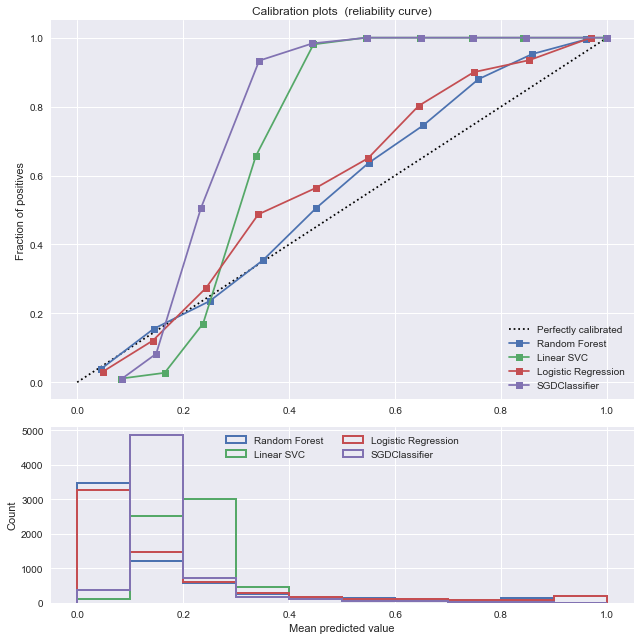

In [82]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

def plotResultsProbabilityCalibration(classifiers, X_train, y_train, X_test, y_test):
    # <!-- collapse=True -->
    plt.figure(figsize=(9, 9))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    for name, clf in classifiers.items():
    
        clf.fit(X_train, y_train)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)
    
        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s" % (name, ))
    
        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)
    
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')
    
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)
    
    plt.tight_layout()
    
# plot top classifiers...
plotResultsProbabilityCalibration(top_classifiers, X_train, Y_train, X_test, Y_test)

### Optionally save to a csv file for further review

In [ ]:
output = pd.DataFrame( data={"id":test_set_df.rev_id, 
                             "original toxicity": test_set_df.toxicity_score, 
                             "Logistic Regression": predictions_best["Logistic Regression"],
                             "Nearest Neighbors": predictions["Nearest Neighbors"],
                             "Linear SVM": predictions["Linear SVM"],
                             "Gradient Boosting": predictions["Gradient Boosting"],
                             "Decision Tree": predictions["Decision Tree"],
                             "Random Forest": predictions_best["Random Forest"],
                             "Neural Net": predictions["Neural Net"],
                             "Multinomial NB": predictions_best["Multinomial NB"],
                             "Bernoulli NB": predictions["Bernoulli NB"],
                             "SGDClassifier": predictions_best["SGDClassifier"],
                             "Linear SVC": predictions_best["Linear SVC"],
                             "Voted":  votedPredictions,
                             "zcomment":test_set_df.comment} )
#output.to_csv('AllPredictions.csv', index=False, quoting=3, escapechar='\\')

# Analyze Other Features

## Visualize other features 
Consider adding these as additional features (not currently used)

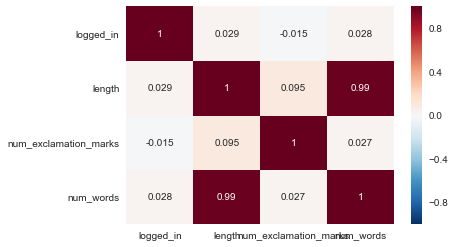

In [88]:
otherfeatures = train_set_df[['logged_in','length','num_exclamation_marks','num_words']]
sns.heatmap(data=otherfeatures.corr(), annot=True)

### Classify other features using Random Forest to find which ones might have preditive power

In [83]:
X_train_other_df = train_set_df[['logged_in','length','num_exclamation_marks','num_words']]
X_test_other_df  =  test_set_df[['logged_in','length','num_exclamation_marks','num_words']]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_other = sc.fit_transform(X_train_other_df)
X_test_other = sc.transform(X_test_other_df)

classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier.fit(X_train_other, Y_train)
        

train_score = classifier.score(X_train_other, Y_train)
test_score = classifier.score(X_test_other, Y_test)

pred = classifier.predict(X_test_other)

report = classification_report(Y_test, pred)
accuracy = metrics.accuracy_score(Y_test, pred)

print(report)
print(accuracy)


             precision    recall  f1-score   support

          0       0.84      0.92      0.88      5196
          1       0.40      0.23      0.29      1190

avg / total       0.76      0.79      0.77      6386

0.79094895083


### Plot the Random Forest feature importance

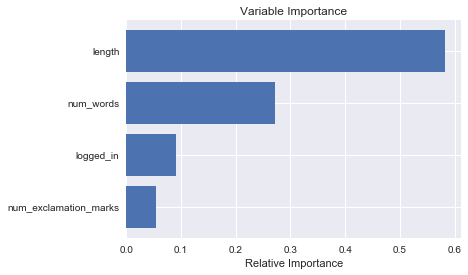

In [84]:
importances = classifier.feature_importances_
sorted_idx = np.argsort(importances)

features = np.array(['logged_in','length','num_exclamation_marks','num_words'])

padding = np.arange(len(features)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

# Combine Bag-of-word Features with other Features and re-classify